# Reasoning behind data cleaning

## Summary

This notebook explains the decisions made when cleaning SSNAP extract v2. To view the cleaning steps performed, please see "01_clean_raw_data.ipynb".

## Aims

(1) Explain decisions related to variables that were included in the clean dataset - for example:
* Why and which results were considered likely to be errors/anomalous.
* How decided on a threshold to identify results that were considered extreme or anomalous.

(2) Explain why some variables from the SSNAP data were not included in the clean dataset.

## Set up

In [1]:
# Import packages and functions
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dataclasses import dataclass

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

# Set the maximum number of columns and rows to 150
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)


# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    raw_path = './../data'
    raw_filename = 'SAMueL ssnap extract v2.csv'
    notebook = '01'


paths = Paths()

In [2]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))
raw_data = pd.read_csv(os.path.join(paths.raw_path, paths.raw_filename),
                       low_memory=False)

In [3]:
def compare_raw_clean(raw_data, clean_data):
    '''
    Merges the raw and clean data using patient ID
    Then presents counts for the remaining columns when ID is dropped
    '''
    compare = pd.merge(left=clean_data, left_on='id',
                       right=raw_data, right_on='PatientId')
    differences = (compare
                   .drop(columns=['id', 'PatientId'], axis=1)
                   .value_counts(dropna=False)
                   .reset_index(name='count'))
    return (differences.sort_values(differences.columns[0]))


def mark_missing(df):
    '''
    Identifies NaN then marks each value as missing data or having data
    '''
    df_missing = (pd.DataFrame(df)
                  .isnull()
                  .apply(lambda x: x.map({True: 'Missing data',
                                          False: 'Have data'})))
    return (df_missing)

## Included variables

### Overview of dataset

In [4]:
# Show shape of the data
data.shape

(357103, 67)

In [5]:
# List all columns and show their data types and proportion of completed data
data_type_complete = pd.DataFrame(
    {'Data type': data.dtypes,
     'Proportion complete': data.count() / data.shape[0]})

# Show all columns
data_type_complete

,Data type,Proportion complete
id,int64,1.000000
stroke_team,object,1.000000
age,float64,1.000000
male,int64,1.000000
infarction,float64,1.000000
onset_to_arrival_time,float64,0.668412
onset_known,int64,1.000000
precise_onset_known,int64,1.000000
onset_during_sleep,int64,1.000000
arrive_by_ambulance,float64,0.999980


### ID

The patient ID from the SSNAP dataset is included, as this provides a consistent identifier between the raw data and different/cleaned versions of the data.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

### Stroke team

No comment - as in SSNAP dataset.

### Age

The SSNAP data provides age and arrival time as categories. These were converted to numerical variables based on the middle value in each category. We do not have data on what the average age or arrival time was for each category, so this is an assumption. There is a chance that, for example, for ages 90 or over, the average age is actually lower than 92.5. However, in lieu of that information, this is considered a reasonable guess.

In [6]:
# Convert raw age to single column
raw_ages = pd.DataFrame(raw_data['PatientId'])
raw_ages['raw_age'] = raw_data[[
    col for col in raw_data if col.startswith('Age')]].idxmax(1)

# Merge with clean and present difference
compare_raw_clean(raw_ages, data[['id', 'age']])

,age,raw_age,count
10,37.5,AgeUnder40,6053
11,42.5,Age40to44,5036
9,47.5,Age45to49,9248
8,52.5,Age50to54,15714
7,57.5,Age55to59,21136
6,62.5,Age60to64,26696
5,67.5,Age65to69,33405
3,72.5,Age70to74,45676
1,77.5,Age75to79,52278
0,82.5,Age80to84,56672


### Gender

No comment - as in SSNAP dataset.

### Stroke type

It is vital that we understand stroke type, so patients were missing stroke type (missing due to having not received a scan) were completely removed from the clean dataset.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [7]:
# Show relationship between missing stoke type and missing arrival to scan time
(mark_missing(raw_data[['S2StrokeType', 'ArrivaltoBrainImagingMinutes']])
 .value_counts()
 .reset_index(name='count'))

,S2StrokeType,ArrivaltoBrainImagingMinutes,count
0,Have data,Have data,358993
1,Missing data,Missing data,1388


### Onset time

This section provides details relating to:
* Onset to arrival time
* Onset known
* Precise onset known
* Onset during sleep

**Zero onset to arrival time**

There are several individuals who have 0 minutes between onset and arrival, and it does not appear to be due to having not arrived by ambulance. Dataset itself only includes patients with out-of-hospital stroke onset, so onset out-of-hospital would not be a possible explanation. Hence, it is felt that we do not trust these times and replaced them as missing.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [8]:
# Count with 0 onset to arrival time in raw data, by whether they
# arrived by ambulance
print('Frequency of onset to arrival = 0 in raw data...')
display(raw_data.groupby('S1ArriveByAmbulance')['OnsettoArrivalMinutes']
        .apply(lambda x: (x == 0).sum())
        .reset_index(name='Count where onset to arrival = 0'))

# Demonstrating there are no times equal to 0 in clean data
print('Frequency of onset to arrival = 0 in clean data...')
display((data['onset_to_arrival_time'] == 0).value_counts())

Frequency of onset to arrival = 0 in raw data...


,S1ArriveByAmbulance,Count where onset to arrival = 0
0,N,11
1,Y,48


Frequency of onset to arrival = 0 in clean data...


False    357103
Name: onset_to_arrival_time, dtype: int64

**Unknown onset time**

Problem: There are many cases where onset time is marked as "unknown" but an onset to arrival time was provided for every person in the dataset. Reasons that support lack of trust in data:
* These typically appear to be the difference between midnight and the arrival time (e.g. of people with an onset to arrival of 1 to 2 hours, nearly all of them have an arrival time of 0000 to 3000).
* Over 99% did not receive thrombolysis - but of those who received thrombolysis, the onset to arrival time was typically quite high and seems unusual (in the clean data, no-one has thrombolysis for an onset to arrival time greater than 12 hours).

Decision: In these cases, onset to arrival time has been set as missing in the clean data...
* Models (inc. outcome models) are typically requiring precise/best estimate (i.e. already dropping onset unknown).
* Onset to arrival time is very important - e.g. models of onset to arrival time for haemorrhagic strokes.
* These patients have not been removed entirely from the data, as this represents a very large proportion of people in the dataset, and could have valuable information - e.g. for descriptive analysis, to describe spread of stroke severity that arrive.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [9]:
# Numbers with unknown onset time
print('Number of people with onset time not known in raw data')
display((raw_data['S1OnsetTimeType'] == 'NK').value_counts())

print('Onset to arrival time when onset time not known in clean data')
data.loc[data['onset_known'] == 0,
         'onset_to_arrival_time'].value_counts(dropna=False)

Number of people with onset time not known in raw data


False    241138
True     119243
Name: S1OnsetTimeType, dtype: int64

Onset to arrival time when onset time not known in clean data


NaN    118411
Name: onset_to_arrival_time, dtype: int64

In [10]:
# Relationship with midnight
# Extract people with onset time not known
unknown_time = raw_data.loc[
    raw_data['S1OnsetTimeType'] == 'NK',
    ['OnsettoArrivalMinutes', 'FirstArrivalTime', 'S2Thrombolysis']]

# Convert onset to arrival to hours and round down
unknown_time['onset_to_arrival_hours'] = (
    np.floor(unknown_time['OnsettoArrivalMinutes']/60))

(unknown_time[['FirstArrivalTime', 'onset_to_arrival_hours']]
 .value_counts()
 .reset_index(name='count')
 .sort_values(by='onset_to_arrival_hours')
 .head(50))

,FirstArrivalTime,onset_to_arrival_hours,count
969,0900to1200,-12.0,1
1111,0600to0900,-1.0,1
656,1800to2100,0.0,2
781,0300to0600,0.0,2
859,2100to2400,0.0,1
743,1200to1500,0.0,2
474,0600to0900,0.0,5
68,0000to3000,0.0,343
678,1500to1800,0.0,2
613,0900to1200,0.0,3


NB    118119
Y        580
N        544
Name: S2Thrombolysis, dtype: int64


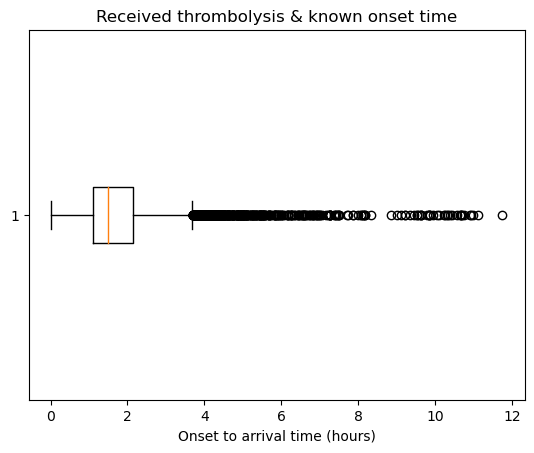

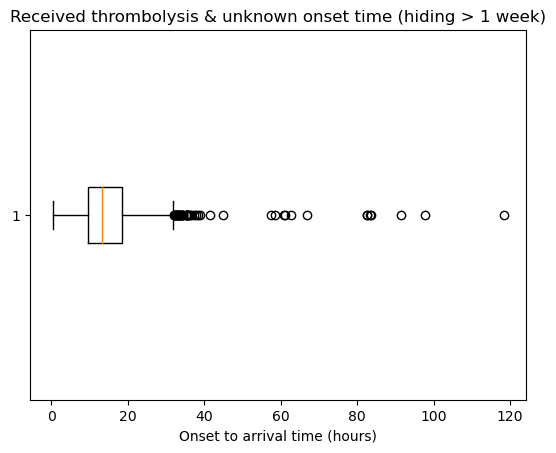

In [11]:
# Number of patients with unknown time who received thrombolysis
print(unknown_time['S2Thrombolysis'].value_counts(dropna=False))

# Extract people who received thrombolysis
onset = raw_data.loc[
    raw_data['S2Thrombolysis'] == 'Y',
    ['S1OnsetTimeType', 'OnsettoArrivalMinutes']]

# Convert onset to arrival from minutes to hours
onset['onset_to_arrival_hours'] = onset['OnsettoArrivalMinutes']/60

# Create dataframes where onset time is known or not
onset_known = onset.loc[onset['S1OnsetTimeType'] != 'NK',
                        'onset_to_arrival_hours']
onset_unknown = onset.loc[((onset['S1OnsetTimeType'] == 'NK') &
                           (onset['onset_to_arrival_hours'] < 168)),
                          'onset_to_arrival_hours']

plt.boxplot(onset_known, vert=False)
plt.xlabel('Onset to arrival time (hours)')
plt.title('Received thrombolysis & known onset time')
plt.show()

plt.boxplot(onset_unknown, vert=False)
plt.xlabel('Onset to arrival time (hours)')
plt.title('Received thrombolysis & unknown onset time (hiding > 1 week)')
plt.show()

**Long onset to arrival time**

Problem: A large onset to arrival time is plausible, but some results are so large that they are considered to be invalid and likely errors in the data, or incredibly anomalous results.

Context: The outcome model requires an onset-to-arrival time of less than a day.

Decision: For dataset as a whole (beyond stricter conditions of modelling), set a threshold of one week. This is a relatively arbritray threshold based on a review of the times below, and consideration of what is likely to be really extreme results and what is normal variability.

These patients are entirely removed from the dataset as the rationale is that they are not of interest as they are not on the emergency stroke pathway (as opposed to setting as missing due to likely invalid data - although some of these results are invalid - e.g. 118 years).

*(Threshold agreed between MA, KP, AL & AH on 26/05/2023).*

<mark>To check.</mark> Decision to drop entirely v.s. set as missing.

In [12]:
# Extract onset to arrival time when onset time is known
onset_arrival = raw_data.loc[
    ((raw_data['S1OnsetTimeType'] == 'P') |
     (raw_data['S1OnsetTimeType'] == 'BE')),
    'OnsettoArrivalMinutes']

In [13]:
# Years
# Convert time from minutes to years then present counts (rounded)
onset_arrival_years = onset_arrival/525600
round(onset_arrival_years).value_counts().sort_index()

0.0      241045
1.0          72
2.0           2
3.0           7
8.0           1
10.0          1
15.0          2
16.0          4
17.0          1
18.0          1
76.0          1
118.0         1
Name: OnsettoArrivalMinutes, dtype: int64

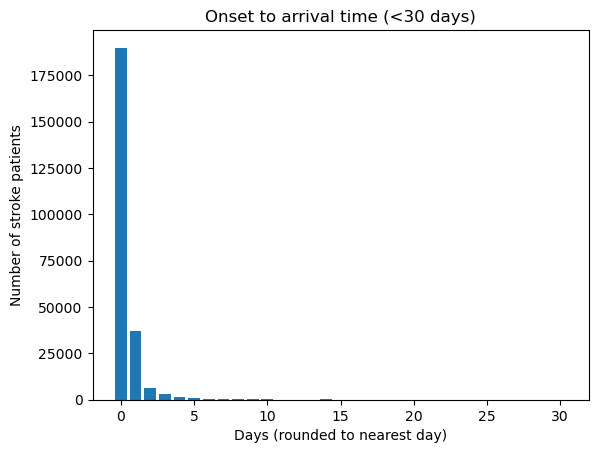

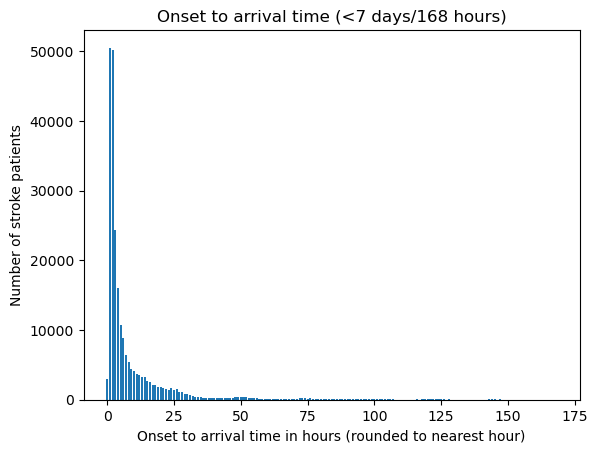

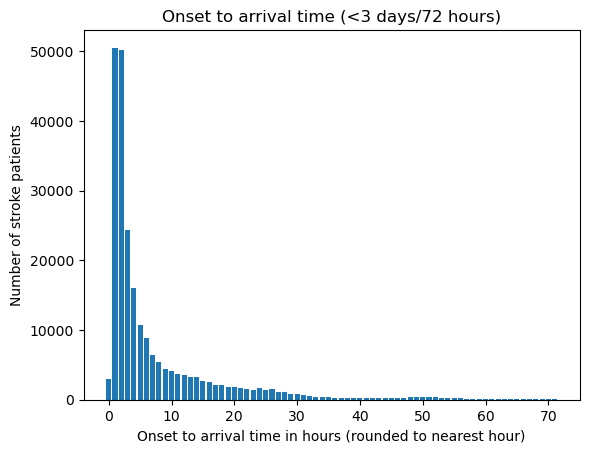

In [14]:
# Days
onset_arrival_days = onset_arrival/1440
onset_arrival_days_count = (round(onset_arrival_days[onset_arrival_days < 30])
                            .value_counts()
                            .sort_index()
                            .reset_index(name='count'))
fig = plt.figure()
plt.bar(onset_arrival_days_count['index'], onset_arrival_days_count['count'])
plt.xlabel('Days (rounded to nearest day)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<30 days)')
plt.show()

# Hours
onset_arrival_hours = onset_arrival/60
onset_arrival_hours_count = (
    round(onset_arrival_hours[onset_arrival_hours < 168])
    .value_counts()
    .sort_index()
    .reset_index(name='count'))

plt.bar(onset_arrival_hours_count['index'],
        onset_arrival_hours_count['count'])
plt.xlabel('Onset to arrival time in hours (rounded to nearest hour)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<7 days/168 hours)')
plt.show()

onset_arrival_hours_shorter = onset_arrival_hours_count[
    onset_arrival_hours_count['index'] < 72]
plt.bar(onset_arrival_hours_shorter['index'],
        onset_arrival_hours_shorter['count'])
plt.xlabel('Onset to arrival time in hours (rounded to nearest hour)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<3 days/72 hours)')
plt.show()

### Ambulance times

In cases where any ambulance times are missing or inappropriate, all ambulance times are set as missing.

In [15]:
# Extract ambulance times
raw_amb_times = raw_data[[
    'CallConnectedtoArrivalMinutes',
    'ArrivalPatientLocationtoArrivalMinutes',
    'DeparturePatientLocationtoArrivalMinutes',
    'WheelsStoptoArrivalMinutes']]
clean_amb_times = data[[
    'call_to_ambulance_arrival_time',
    'ambulance_on_scene_time',
    'ambulance_travel_to_hospital_time',
    'ambulance_wait_time_at_hospital']]

**Missing times**

The clean dataset either requires all times to be complete or all to be missing.

Although there are apx. 15,000 patients only missing WheelsStoptoArrivalMinutes, this means they are missing ambulance_travel_to_hospital_time and ambulance_wait_time_at_hospital, so this was not included. This also allows consistency in decision on what to keep when data on ambulance times is missing.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [16]:
# Presence of missing ambulance times in clean data
(clean_amb_times
 .isnull()
 .apply(lambda x: x.map({True: 'Missing time', False: 'Has time'}))
 .value_counts()
 .reset_index(name='count'))

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,Missing time,Missing time,Missing time,Missing time,271516
1,Has time,Has time,Has time,Has time,85587


In [17]:
# Missing ambulance times in raw data
(raw_amb_times
 .isnull()
 .apply(lambda x: x.map({True: 'Missing time', False: 'Has time'}))
 .value_counts()
 .reset_index(name='count'))

,CallConnectedtoArrivalMinutes,ArrivalPatientLocationtoArrivalMinutes,DeparturePatientLocationtoArrivalMinutes,WheelsStoptoArrivalMinutes,count
0,Missing time,Missing time,Missing time,Missing time,251882
1,Has time,Has time,Has time,Has time,92958
2,Has time,Has time,Has time,Missing time,15421
3,Has time,Has time,Missing time,Missing time,87
4,Has time,Missing time,Missing time,Has time,8
5,Has time,Missing time,Missing time,Missing time,7
6,Missing time,Has time,Has time,Has time,5
7,Missing time,Has time,Missing time,Missing time,5
8,Has time,Missing time,Has time,Has time,3
9,Missing time,Has time,Has time,Missing time,3


**Negative times**

We get negative times when:
* A time is greater than the subsequent time in the sequence (e.g. call_to_ambulance_arrival is ArrivalPatient - CallConnected, but will be negative if CallConnected is larger than ArrivalPatient)
* WheelsStoptoArrivalMinutes is positive (as calculated by 0 - WheelsStop)

The clean dataset contains no negative times.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [18]:
(raw_data['CallConnectedtoArrivalMinutes'] >
 raw_data['ArrivalPatientLocationtoArrivalMinutes']).value_counts()

False    360309
True         72
dtype: int64

In [19]:
(raw_data['ArrivalPatientLocationtoArrivalMinutes'] >
 raw_data['DeparturePatientLocationtoArrivalMinutes']).value_counts()

False    360229
True        152
dtype: int64

In [20]:
(raw_data['DeparturePatientLocationtoArrivalMinutes'] >
 raw_data['WheelsStoptoArrivalMinutes']).value_counts()

False    360011
True        370
dtype: int64

In [21]:
(raw_data['WheelsStoptoArrivalMinutes'] > 0).value_counts()

False    354343
True       6038
Name: WheelsStoptoArrivalMinutes, dtype: int64

In [22]:
(clean_amb_times < 0).value_counts().reset_index(name='count')

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,False,False,False,False,357103


**Times equal to zero**

It is plausible that the wait time at the hospital might be 0 minutes. However, a time of 0 minutes is not plausible for:
* Call received to ambulance arrival
* Length of time that ambulance is on scene
* Travel time to hospital

Hence, in those cases, all times are set as NaN.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [23]:
(raw_amb_times == 0).value_counts().reset_index(name='count')

,CallConnectedtoArrivalMinutes,ArrivalPatientLocationtoArrivalMinutes,DeparturePatientLocationtoArrivalMinutes,WheelsStoptoArrivalMinutes,count
0,False,False,False,False,349050
1,False,False,False,True,11158
2,False,False,True,False,118
3,False,False,True,True,19
4,False,True,False,False,19
5,True,False,False,False,17


In [24]:
(clean_amb_times == 0).value_counts().reset_index(name='count')

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,False,False,False,False,346001
1,False,False,False,True,11102


**Long call to ambulance time**

Problem: Although a time at 98 hours may be a valid and real time that happened, it is very anomalous and is not what we would reasonably expect to happen in future - doesn't reflect normal variation in system - and so is considered appropriate to set that time as missing. There is one very high time (120 years) that is also definietely anomalous.

Decision: Set a threshold of 24 hours (relatively arbritrary - based on spread of results and judgement on what is a very extreme result). Completely dropped (rather than set as missing) as feel extreme values (but not necessarily invalid in every case).

*(Threshold agreed between MA, KP, AL & AH on 26/05/2023).*

<mark>To check.</mark> Decision to drop entirely v.s. set as missing.

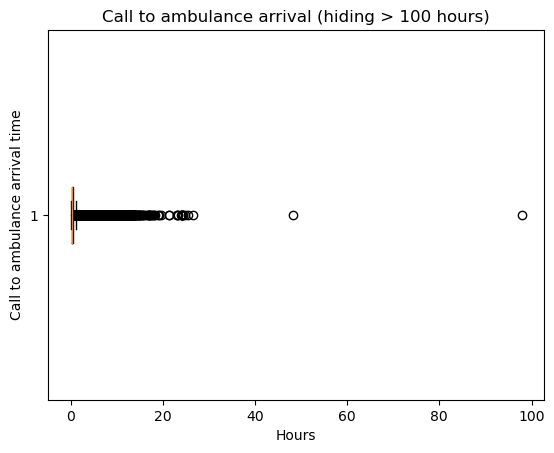

0.0     74679
1.0     26572
2.0      4266
3.0      1341
4.0       638
5.0       306
6.0       196
7.0        99
8.0        86
9.0        67
10.0       30
11.0       21
12.0       20
13.0       16
14.0       15
15.0        8
16.0        4
17.0        6
18.0        4
19.0        2
20.0        1
21.0        2
23.0        3
24.0        7
25.0        2
27.0        1
48.0        1
98.0        1
dtype: int64

In [25]:
# Extract call to ambulance arrival time from raw data
# and convert to hours
call_amb_hours = (
    raw_data['ArrivalPatientLocationtoArrivalMinutes'] -
    raw_data['CallConnectedtoArrivalMinutes'])/60

# Drop NA, really high value (1061774), and negative
call_amb_hours_filter = call_amb_hours[
    (call_amb_hours < 100) & ~(call_amb_hours < 0)].dropna()

plt.boxplot(call_amb_hours_filter, vert=0)
plt.xlabel('Hours')
plt.ylabel('Call to ambulance arrival time')
plt.title('Call to ambulance arrival (hiding > 100 hours)')
plt.show()

round(call_amb_hours_filter).value_counts().sort_index()

In [26]:
# Demonstration of max time in cleaned data
np.nanmax(data['call_to_ambulance_arrival_time'])/60

24.0

**Long ambulance on scene time**

Problem: In the raw data, time on scene increments from 0 to 6 hours, then leaps to 24, then two totally implausible, although those are now dropped due to other data cleaning actions.

Decision: Cut-off at 12 hours (arbritrary - based on range of values and judgement of what is so long that it is likely to be invalid). Since these are times that are considered invalid, all ambulance times for these patients were set as missing (since times are incremental, so invalid times have knock-on effect) - rather than being dropped from the dataset entirely.

*(Threshold agreed between MA, KP, AL & AH on 26/05/2023).*

<mark>To check.</mark> Decision to drop entirely v.s. set as missing.

In [27]:
# Convert time from minutes, filter from non-negative,
# and present counts (rounded)
amb_sc_hours = data['ambulance_on_scene_time']/60
amb_sc_hours = amb_sc_hours[amb_sc_hours >= 0]
round(amb_sc_hours).value_counts().sort_index()

0.0    40189
1.0    44296
2.0     1005
3.0       80
4.0        9
5.0        4
6.0        3
7.0        1
Name: ambulance_on_scene_time, dtype: int64

In [28]:
# From raw data
raw_scene_time = (
    raw_data['DeparturePatientLocationtoArrivalMinutes'] -
    raw_data['ArrivalPatientLocationtoArrivalMinutes'])/60
raw_scene_time = raw_scene_time[raw_scene_time >= 0]
round(raw_scene_time).value_counts().sort_index()

0.0        51582
1.0        55290
2.0         1241
3.0           94
4.0           14
5.0            4
6.0            3
7.0            1
8.0            1
10.0           2
24.0           1
8760.0         1
17520.0        1
dtype: int64

**Long ambulance travel to hospital time**

Problem: Most times are around 0 or 1 hours, and some are around 2 to 5 hours - but then there are times of 10 to 24 hours, as well as some totally implausible times.

Decision: Cut-off at 6 hours (arbritrary - based on range of values and decision on what times are so large that they are likely to be invalid/erronaeous). Setting times as missing (rather than dropping entirely) as this is on basis of them being invalid (rather than extreme but plausible).

*(Threshold agreed between MA & AH on 16/05/2023).*

<mark>To check.</mark>
* (KP + AL) Threshold
* (MA + KP + AL) decision to drop entirely v.s. set as missing

In [29]:
# From raw data
raw_travel_time = (
    raw_data['WheelsStoptoArrivalMinutes'] -
    raw_data['DeparturePatientLocationtoArrivalMinutes'])/60
raw_travel_time = raw_travel_time[raw_travel_time >= 0]
round(raw_travel_time).value_counts().sort_index()

0.0          78514
1.0          13997
2.0             57
3.0              4
4.0              1
5.0              2
10.0             6
11.0             2
14.0             1
23.0             1
24.0             5
240.0            1
1488.0           1
8760.0           1
1048835.0        1
1052038.0        1
1060339.0        1
dtype: int64

In [30]:
# Demonstration of max time in cleaned data
np.nanmax(data['ambulance_travel_to_hospital_time'])/60

3.85

**Long ambulance wait at hospital time**

Problem: Majority of patients have quite a short wait time, but there are wait times that increment up and up in small steps (e.g. from a few hours through to 14, 15, 16 ..20, 22, 23... 43...). Many of these times are implausible (including times where it was weeks)

Decision: Set threshold of 12 hours (arbritrary - based on evaluation of range of times, and judgement on what is likely to be invalid).

*(Threshold agreed between MA & AH on 16/05/2023).*

<mark>To check.</mark>
* (KP + AL) Threshold
* (MA + KP + AL) Decision to drop v.s. set as missing

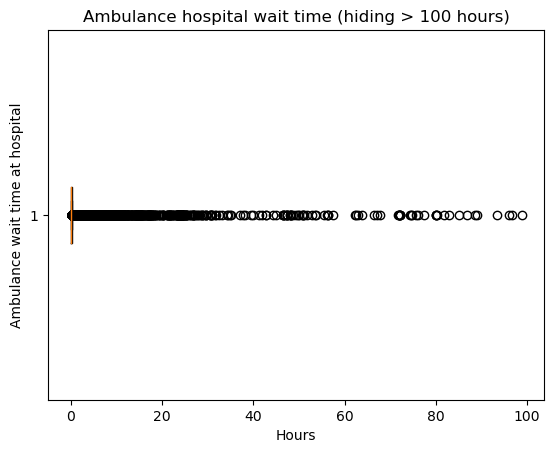

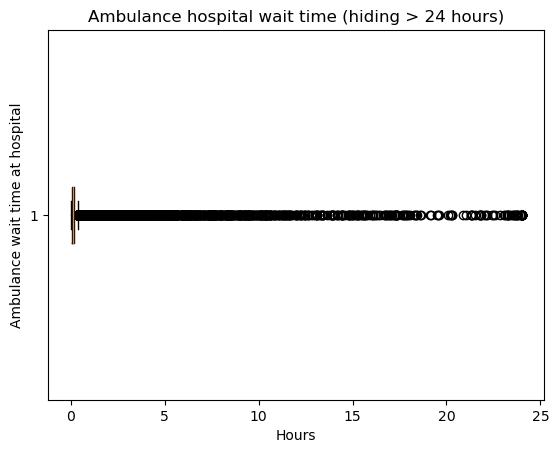

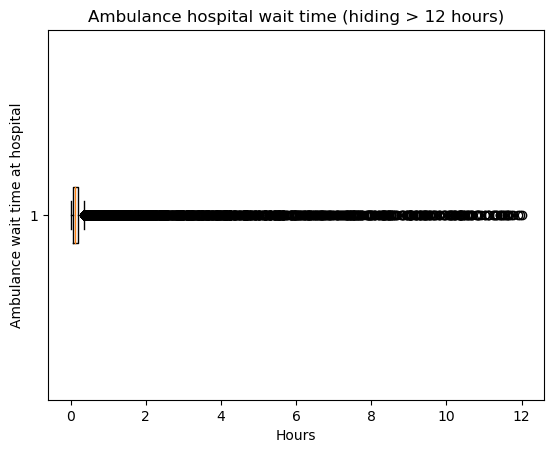

In [31]:
# Find ambulance wait time at hospital in hours
amb_wait_hours = (0 - raw_data['WheelsStoptoArrivalMinutes'])/60

# Remove negative
amb_wait_hours = amb_wait_hours[amb_wait_hours >= 0]

plt.boxplot(amb_wait_hours[amb_wait_hours <= 100], vert=0)
plt.xlabel('Hours')
plt.ylabel('Ambulance wait time at hospital')
plt.title('Ambulance hospital wait time (hiding > 100 hours)')
plt.show()

plt.boxplot(amb_wait_hours[amb_wait_hours <= 24], vert=0)
plt.xlabel('Hours')
plt.ylabel('Ambulance wait time at hospital')
plt.title('Ambulance hospital wait time (hiding > 24 hours)')
plt.show()

plt.boxplot(amb_wait_hours[amb_wait_hours <= 12], vert=0)
plt.xlabel('Hours')
plt.ylabel('Ambulance wait time at hospital')
plt.title('Ambulance hospital wait time (hiding > 12 hours)')
plt.show()

In [32]:
# Max wait time in cleaned data (hours)
np.nanmax(data['ambulance_wait_time_at_hospital'])/60

12.0

**Times when didn't arrive by ambulance**

There are some individuals who have ambulance times yet are marked as having not arrived by ambulance. In these cases, we are not certain which of these times are true. Hence, all times have been marked as NaN for these individuals.

*(Decision agreed between MA, KP, AL & AH on 26/05/2023).*

In [33]:
# Number of times this is the case in the raw data
times_but_no_amb = (
    raw_data['S1ArriveByAmbulance'] == 'N') & (
        (raw_data['CallConnectedtoArrivalMinutes'].notnull()) |
        (raw_data['ArrivalPatientLocationtoArrivalMinutes'].notnull()) |
        (raw_data['DeparturePatientLocationtoArrivalMinutes'].notnull()) |
        (raw_data['WheelsStoptoArrivalMinutes'].notnull()))
times_but_no_amb.value_counts()

False    360372
True          9
dtype: int64

In [34]:
# Demonstrating these are removed from the clean data
clean_times_but_no_amb = (
    data['arrive_by_ambulance'] == 0) & (
        (data['call_to_ambulance_arrival_time'].notnull()) |
        (data['ambulance_on_scene_time'].notnull()) |
        (data['ambulance_travel_to_hospital_time'].notnull()) |
        (data['ambulance_wait_time_at_hospital'].notnull()))
clean_times_but_no_amb.value_counts()

False    357103
dtype: int64

### Day, month, year and time of arrival

No comment for day, month and year (just pulled from dataset).

For time of arrival, to convert from a categorical to numeric variable, we set arrival time to the start of each bracket. It is not a concern that this is different to age (where set to middle of the bracket), as the meaningful information for arrival time is the difference between each time (i.e. 3 units), which would be the same regardless of whether the start, middle or end of the bracket was used. The start was chosen as this was felt easier to understand than a half time, and as this is consistent with SAMueL1.

*(Decision agreed between MA, KP, AL & AH on 19/05/2023).*

In [35]:
# Extract relevant columns and merge
compare_time = pd.merge(
    left=data[['id', 'arrival_time_3_hour_period']], left_on='id',
    right=raw_data[['PatientId', 'FirstArrivalTime']], right_on='PatientId')

# Table illustrating change from categorical to numerical variable
(compare_time
 .drop(['PatientId', 'id'], axis=1)
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='arrival_time_3_hour_period'))

,arrival_time_3_hour_period,FirstArrivalTime,count
6,0,0000to3000,15569
7,3,0300to0600,11447
5,6,0600to0900,24900
0,9,0900to1200,81323
1,12,1200to1500,77807
2,15,1500to1800,63770
3,18,1800to2100,49990
4,21,2100to2400,32297


### Scan, thrombolysis and thrombectomy

**Arrival to scan time**

Problem: Can be very long (e.g. 2000 hours = 83 days, 8000 hours = 333 days).

Context:
* We only request out-of-hospital onset, so this is not due to in-hospital stroke where arrived at hospital prior to having had a stroke.
* However, it might be the case that people had a stroke out-of-hospital, arrived (e.g. by ambulance) for another reason, and only later realised had a stroke (or there was something more severe being prioritised).
* It shouldn't really be more than four hours - and it should hopefully be a matter of minutes. Often, we filter to onset-to-arrival < 4 hours and arrival-to-scan < 4 hours.

Decision: <mark>To discuss</mark>

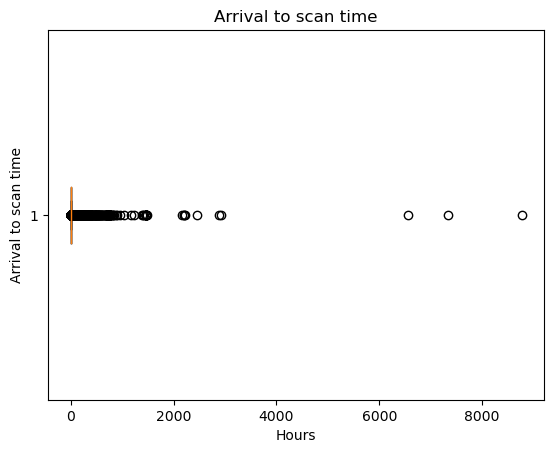

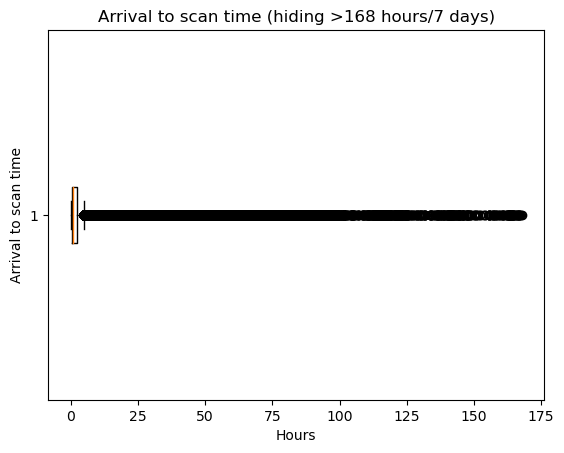

True     0.99868
False    0.00132
Name: ArrivaltoBrainImagingMinutes, dtype: float64


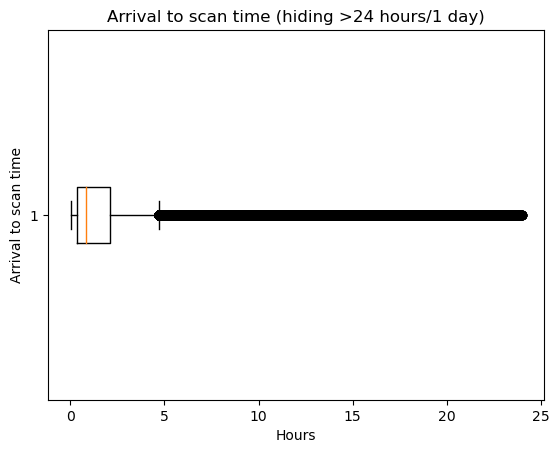

True     0.981749
False    0.018251
Name: ArrivaltoBrainImagingMinutes, dtype: float64


In [36]:
# Convert time from minutes to hours and drop missing
arr_scan_hours = (raw_data['ArrivaltoBrainImagingMinutes']/60).dropna()

# Create boxplot
plt.boxplot(arr_scan_hours, vert=0)
plt.xlabel('Hours')
plt.ylabel('Arrival to scan time')
plt.title('Arrival to scan time')
plt.show()

# Filter to time within one week
plt.boxplot(arr_scan_hours[arr_scan_hours < 168], vert=0)
plt.xlabel('Hours')
plt.ylabel('Arrival to scan time')
plt.title('Arrival to scan time (hiding >168 hours/7 days)')
plt.show()
print((arr_scan_hours < 168).value_counts(normalize=True))

# Filter to time within one day
plt.boxplot(arr_scan_hours[arr_scan_hours < 24], vert=0)
plt.xlabel('Hours')
plt.ylabel('Arrival to scan time')
plt.title('Arrival to scan time (hiding >24 hours/1 day)')
plt.show()
print((arr_scan_hours < 24).value_counts(normalize=True))

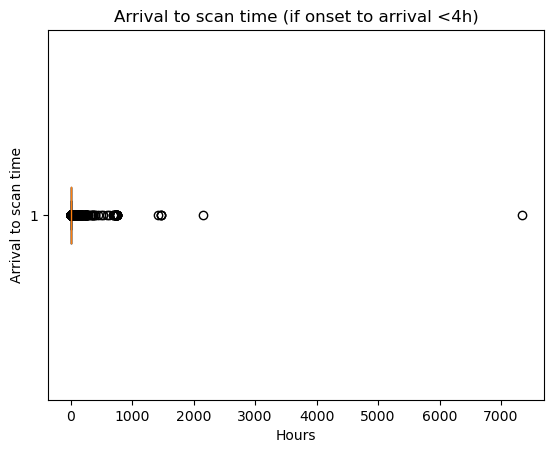

False    0.617326
True     0.382674
Name: onset_to_arrival_time, dtype: float64


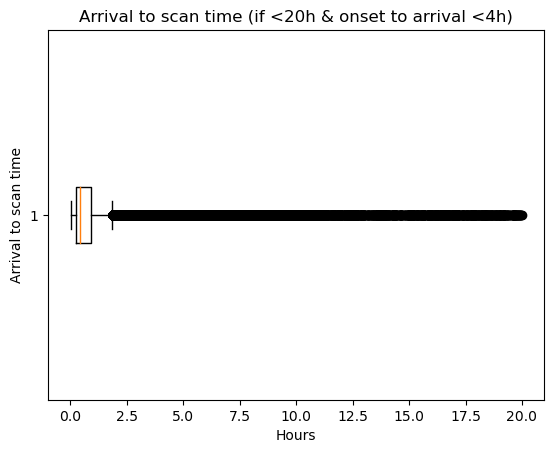

True     0.990589
False    0.009411
Name: arrival_to_scan_time, dtype: float64


In [37]:
# Filter to onset to arrival minutes < 4 hours (240 minutes)
onset_four_arr_scan = data.loc[
    data['onset_to_arrival_time'] < 240,
    'arrival_to_scan_time']/60

# Create boxplot
plt.boxplot(onset_four_arr_scan, vert=0)
plt.xlabel('Hours')
plt.ylabel('Arrival to scan time')
plt.title('Arrival to scan time (if onset to arrival <4h)')
plt.show()
print((data['onset_to_arrival_time'] < 240).value_counts(normalize=True))

# Filter to arrival to scan < 20 hours
plt.boxplot(onset_four_arr_scan[onset_four_arr_scan < 20], vert=0)
plt.xlabel('Hours')
plt.ylabel('Arrival to scan time')
plt.title('Arrival to scan time (if <20h & onset to arrival <4h)')
plt.show()
print((onset_four_arr_scan < 20).value_counts(normalize=True))

**Scan to thrombolysis time**

A scan to thrombolysis time of 0 is considered relatively plausible (that it could be very quick) and could be part of noise of data but not invalid results, so these have not been removed from the clean data.

*(Decision agreed between MA & AH on 16/05/2023).*

<mark>To check.</mark> That KP + AL agree.

In [38]:
(data['scan_to_thrombolysis_time'] == 0).value_counts()

False    356812
True        291
Name: scan_to_thrombolysis_time, dtype: int64

**Thrombolysis**

No comment - Y (yes) to 1, and N or NB (no or no but) to 0.

**Thrombectomy**

If ArrivaltoArterialPunctureMinutes is NaN, we conclude they did not have a thrombectomy. Is there a possibility that this could be missing for anyone who did have a thrombectomy? No, the SSNAP team suggested that this is how we identify people who have had a thrombectomy, and that everyone who had one should have a time.

In [39]:
# Show where raw data had or was missing data, then compare with clean data
raw_thrombectomy = mark_missing(raw_data['ArrivaltoArterialPunctureMinutes'])
raw_thrombectomy['PatientId'] = raw_data['PatientId']
compare_raw_clean(raw_thrombectomy,
                  data[['id', 'thrombectomy']])

,thrombectomy,ArrivaltoArterialPunctureMinutes,count
0,0,Missing data,352760
1,1,Have data,4343


### Comorbidities

**Diagnoses.** New atrial fibrillation diagnosis is missing data (should be complete for all cases where AtrialFibrillation = N), but still included in cleaned dataset for some descriptive analysis.

In [40]:
((raw_data[['S2CoMAtrialFibrillation', 'S2NewAFDiagnosis']]
  .value_counts(dropna=False)
  .reset_index(name='count')
  .sort_values(by='S2NewAFDiagnosis')))

,S2CoMAtrialFibrillation,S2NewAFDiagnosis,count
0,N,N,185842
3,N,Y,13133
1,N,NaN,95809
2,Y,NaN,65597


**Anticoagulants and antiplatelets.** Among possible answers to these variables in the raw data were no (N) and no but (NB) - we are not aware what the difference between these are, but see no reason why there would be an issue of setting both as 0 in the clean data.

<mark>To change?</mark> We don't know that NaN definetely means No. Should these be marked as NaN rather than 0 in the clean data?

<mark>Changed.</mark> If anticoagulent use marked as no, but a specific anticoagulent is marked as true, all anticoagulent results are set as NaN, as we would not know which result is true.

In [41]:
# Inspection of where anticoagulent data is missing
(raw_data[['S2CoMAtrialFibrillation', 'S2CoMAFAnticoagulent']]
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by=['S2CoMAtrialFibrillation', 'S2CoMAFAnticoagulent']))

,S2CoMAtrialFibrillation,S2CoMAFAnticoagulent,count
0,N,N,186543
4,N,NB,11387
5,N,Y,6808
1,N,NaN,90046
3,Y,N,19014
6,Y,NB,6578
2,Y,Y,40004
7,Y,NaN,1


In [42]:
# Discrepancy between anticoagulant use and type of anticoagulant
raw_data.loc[
    (((raw_data['S2CoMAFAnticoagulent'] == 'N') |
      (raw_data['S2CoMAFAnticoagulent'] == 'NB')
      ) &
     ((raw_data['S2CoMAFAnticoagulentVitK'] == 1) |
      (raw_data['S2CoMAFAnticoagulentDOAC'] == 1) |
      (raw_data['S2CoMAFAnticoagulentHeparin'] == 1))),
    ['S2CoMAFAnticoagulent', 'S2CoMAFAnticoagulentVitK',
     'S2CoMAFAnticoagulentDOAC', 'S2CoMAFAnticoagulentHeparin']]

,S2CoMAFAnticoagulent,S2CoMAFAnticoagulentVitK,S2CoMAFAnticoagulentDOAC,S2CoMAFAnticoagulentHeparin
127274,N,0.0,1.0,0.0


### Prior disability

No comment.

### NIHSS data

No comment.

### Death and outcome data

Nearly everyone who is marked to have died also had a Modified Rankin Scale (mRS) score of 6, which indicates death. There are some inconsistencies in this data:
* mrs=6 and discharge=died but death=0 (n=9)
* death=0 and discharge=community team but mrs=6 (n=1)
* discharge=died and death=1 but mrs=missing (n=2)

In the first two cases, as we cannot be certain which result is true, propose both variables are set as missing.

In the final case, as it is not inconsistency but instead discharge disability missing (which is true for lots of people), and as there is agreement between death and discharge destination, could either set discharge as 6 (but that would falsely change number with mrs reported or leave as is, or set all as missing).

<mark>To change.</mark> Check that everyone agrees with this decision.

In [43]:
(data.loc[((data['death'] == 1) |
          (data['discharge_disability'] == 6) |
          (data['discharge_destination'] == 'died')),
          ['death', 'discharge_disability', 'discharge_destination']]
 .value_counts(dropna=False))

death  discharge_disability  discharge_destination
1      6.0                   died                     49745
0      6.0                   died                         9
1      NaN                   died                         2
0      6.0                   community_team_or_esd        1
dtype: int64

### Reasons for no thrombolysis

No comment - as in SSNAP dataset - includes "no" and "no but" reasons.

### Summary: number of patients removed during data cleaning

Below is a summary of the total number of patients completely removed from the full dataset during the data cleaning process.

In [44]:
# Print change to number of patients in dataset
original_n = len(raw_data.index)
clean_n = len(data.index)
drop_n = original_n - clean_n
print(
    f'''
    Original dataset contained {original_n} patients.
    We have removed {drop_n} patients.
    Cleaned dataset contains {clean_n} patients.
    ''')


    Original dataset contained 360381 patients.
    We have removed 3278 patients.
    Cleaned dataset contains 357103 patients.
    


## Excluded variables

### Anticoagulent type

The type of anticoagulent is missing for alot of patients (and could be missing for others, if they are marked as having received one, but actually received multiple). Could it be that they received a type of anticoagulent that is not listed? There is covariance between receiving anticoagulents and type of anticoagulent received, and hence, to resolve the missing data issue and deal with covariance, it was suggested that only overall use of anticoagulants is kept, and type is dropped.

Although we don't include type in the dataset, it is used to support cleaning (to identify discrepancies in use of anticoagulants).

<mark>Changed.</mark> Previously included anticoagulent type.

In [45]:
# Correlation between anticoagulent columns
comorbid_marker = {'Y': 1, 'N': 0, 'NB': 0, np.nan: np.nan}
anticoag = (pd.DataFrame(
    raw_data['S2CoMAFAnticoagulent'].map(comorbid_marker))
    .join(raw_data[['S2CoMAFAnticoagulentVitK',
                    'S2CoMAFAnticoagulentDOAC',
                    'S2CoMAFAnticoagulentHeparin']]))
anticoag.dropna().corr()

,S2CoMAFAnticoagulent,S2CoMAFAnticoagulentVitK,S2CoMAFAnticoagulentDOAC,S2CoMAFAnticoagulentHeparin
S2CoMAFAnticoagulent,1.000000,0.478682,0.828293,0.091863
S2CoMAFAnticoagulentVitK,0.478682,1.000000,-0.063735,-0.004064
S2CoMAFAnticoagulentDOAC,0.828293,-0.063735,1.000000,-0.010471
S2CoMAFAnticoagulentHeparin,0.091863,-0.004064,-0.010471,1.000000


### INR

**Comparing INR, INR High and INR not known**

* INR High is only marked as true in 31 cases
* In all these cases, they are missing INR result and marked as INR not checked.

Hence, there are serious inconsistencies between the three INR columns.

In [46]:
# Look at proportion with INR high and INR result
inr_high = mark_missing(raw_data['S2INR'])
inr_high['S2INRHigh'] = raw_data['S2INRHigh']
inr_high['S2INRNK'] = raw_data['S2INRNK']
(inr_high[['S2INR', 'S2INRHigh', 'S2INRNK']]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,S2INR,S2INRHigh,S2INRNK,count
0,Missing data,0.0,0.0,238845
1,Missing data,NaN,NaN,112376
2,Have data,0.0,0.0,8506
3,Missing data,0.0,1.0,623
4,Missing data,1.0,0.0,31


**Looking further into INR**

Measurement of INR is contingent on whether patients were on Vitamin K antagonists (inc. Warfarin) before their stroke.

*In relation to Mike's comment that expect people with INR measurements to be on anticoagulants*

In [47]:
# Find whether missing INR or not, and VitK value
inr = mark_missing(raw_data['S2INR'])
inr['anticoag_vitk'] = raw_data['S2CoMAFAnticoagulentVitK']

# Look at those counts
inr_counts = inr.value_counts(dropna=False).reset_index(name='count')
inr_counts

,S2INR,anticoag_vitk,count
0,Missing data,0.0,238845
1,Missing data,NaN,112376
2,Have data,1.0,8506
3,Missing data,1.0,654


There are equal numbers with best estimate v.s. precise v.s. not known onset, who have INR measurement

*In relation to Mike's comment that wouldn't expect INR measurement when don't know onset*

In [48]:
inr_onset = inr.copy()
inr_onset['S1OnsetTimeType'] = raw_data['S1OnsetTimeType']
(inr_onset[inr_onset['anticoag_vitk'] == 1]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,S2INR,anticoag_vitk,S1OnsetTimeType,count
0,Have data,1.0,BE,2949
1,Have data,1.0,P,2876
2,Have data,1.0,NK,2681
3,Missing data,1.0,BE,258
4,Missing data,1.0,NK,231
5,Missing data,1.0,P,165


For patients who were on Vitamin K antagonists, 92.8% have INR measurements and 7.1% are missing data.

In [49]:
# Look at proportion of people on VitK with INR data
vitk = inr_counts[inr_counts['anticoag_vitk'] == 1]
vitk['count'] / vitk['count'].sum()

2    0.928603
3    0.071397
Name: count, dtype: float64

INR measurements are present for patients with both stroke types.

*In relation to Mike's comment asking if they measure when its haemorrhage*

In [50]:
inr_stroke = inr.drop('anticoag_vitk', axis=1)
inr_stroke['stroke_type'] = raw_data['S2StrokeType']

(inr_stroke
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='stroke_type'))

,S2INR,stroke_type,count
0,Missing data,I,308504
2,Have data,I,6637
1,Missing data,PIH,42012
3,Have data,PIH,1840
4,Missing data,NaN,1359
5,Have data,NaN,29


Can see that individuals with INR measurement only also had thrombolysis when values were less than 4. Individuals with higher INR are mostly in thrombolysis=NB, with one in thrombolysis=N.

*In relation to Mike's comment about relationship between INR measurement, haemorrhage and thrombolysis - and that would expect high INR to not have thrombolysis*

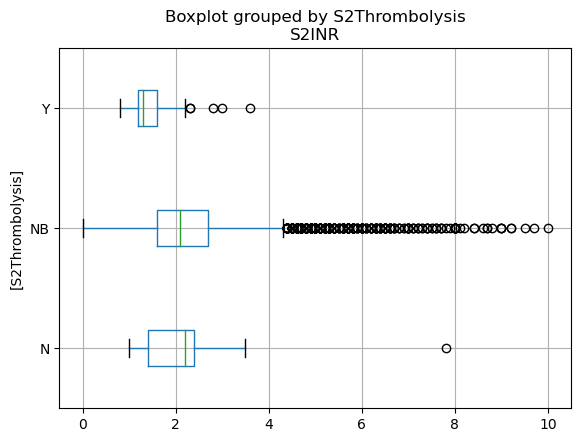

In [51]:
# Extract INR results and whether received thrombolysis
inr_thrombolysis = raw_data.loc[
    ~raw_data['S2INR'].isnull(),
    ['S2INR', 'S2Thrombolysis']]

inr_thrombolysis.boxplot(by='S2Thrombolysis', vert=False)
plt.show()

### Mobile data to arrival

This is missing for the majority of patients. Everyone who has MobileDatatoArrivalMinutes also have data for CallConnectedtoArrivalMinutes, so this variable is not needed.

In [52]:
(mark_missing(raw_data[['MobileDatatoArrivalMinutes',
                        'CallConnectedtoArrivalMinutes']])
 .value_counts()
 .reset_index(name='count'))

,MobileDatatoArrivalMinutes,CallConnectedtoArrivalMinutes,count
0,Missing data,Missing data,251896
1,Missing data,Have data,92414
2,Have data,Have data,16071


### TIA in last month

This is missing for the majority of patients. Also, it should only be completed if 2.1.5 (had stroke/TIA) is marked as yes, but this is not the case. Hence, not included in clean dataset.

In [53]:
(raw_data[['S2CoMStrokeTIA', 'S2TIAInLastMonth']]
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='S2CoMStrokeTIA'))

,S2CoMStrokeTIA,S2TIAInLastMonth,count
0,N,NaN,268486
5,N,N,342
6,N,NK,42
1,Y,NaN,64115
2,Y,N,22205
3,Y,NK,3845
4,Y,Y,1346


### Stroke unit death

Not included in clean dataset, as we are not currently interested in the location of death.

### Pre-hospital impression

S1PreHospitalImpression - not certain what it is (might be to do with what paramedic think is the diagnosis - e.g. fast positive) and did not ask for it, not included in cleaned dataset.